In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gnnboundary
import torch
import matplotlib.pyplot as plt

In [3]:
dataset_name = "motif"

In [4]:
def get_dataset_setup(dataset_name):
    datasets = {
        "motif": gnnboundary.MotifDataset,
        "collab": gnnboundary.CollabDataset,
    }
    models = {
        "motif": lambda ds: (gnnboundary.GCNClassifier(
            node_features=len(ds.NODE_CLS),
            num_classes=len(ds.GRAPH_CLS),
            hidden_channels=6,
            num_layers=3,
        ), "ckpts/motif.pt"),
        "collab": lambda ds: (gnnboundary.GCNClassifier(
            node_features=len(ds.NODE_CLS),
            num_classes=len(ds.GRAPH_CLS),
            hidden_channels=64,
            num_layers=5,
        ), "ckpts/collab.pt"),
    }
    
    dataset = datasets[dataset_name](seed=12345)
    model, path = models[dataset_name](dataset)
    model.load_state_dict(torch.load(path))
    return dataset, model

In [5]:
dataset, model = get_dataset_setup(dataset_name)

In [6]:
def get_trainer(cls_idx, dataset, model):
    sampler = gnnboundary.GraphSampler(
        max_nodes=25,
        temperature=0.15,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True,
    )

    criterion = gnnboundary.WeightedCriterion([
        dict(key="logits", criterion=gnnboundary.DynamicBalancingBoundaryCriterion(
            classes=list(cls_idx), alpha=1, beta=2
        ), weight=25),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        # dict(key="logits", criterion=gnnboundary.MeanPenalty(), weight=1),
        dict(key="omega", criterion=gnnboundary.NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=gnnboundary.NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        # dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ])

    def get_optimizer(sampler):
        optimizer = torch.optim.SGD(sampler.parameters(), lr=1)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
        return [optimizer], scheduler
    
    # optimizer = torch.optim.SGD(sampler.parameters(), lr=1)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

    trainer = gnnboundary.Trainer(
        sampler=sampler,
        discriminator=model,
        criterion=criterion,
        optim_factory=get_optimizer,
        # optimizer=optimizer,
        # scheduler=scheduler,
        dataset=dataset,
        budget_penalty=gnnboundary.BudgetPenalty(budget=10, order=2, beta=1),
    )
    return trainer


def train_eval(cls_idx, dataset, model, num_runs, num_samples, train_args):
    train_args["target_probs"] = {cls_idx[0]: train_args["target_probs"], cls_idx[1]: train_args["target_probs"]}
    trainer = get_trainer(cls_idx, dataset, model)
    scores, bpws = trainer.batch_generate(cls_idx, total=num_runs, num_boundary_samples=num_samples, **train_args)
    
    means = torch.stack([s["mean"] for s in scores])
    stds = torch.stack([s["std"] for s in scores])
    best_idx = (means[:, :2] - 0.5).abs().sum(dim=1).argmin().item()
    
    print(f"Classes: {cls_idx}", f"Num runs: {num_runs}, num samples: {num_samples}", sep="\n", end="\n\n")
    print(f"Best run: {best_idx}", f"means: {means[best_idx]}", f"stds: {stds[best_idx]}", sep="\n", end="\n\n")
    print(f"Mean of means: {means.mean(dim=0)}", f"Mean of stds: {stds.mean(dim=0)}", sep="\n")
    
    return means, stds, bpws

In [7]:
train_args = dict(
    iterations=500,
    target_probs=(0.45, 0.55),
    # show_progress=False,
    target_size=60,
    w_budget_init=1,
    w_budget_inc=1.15,
    w_budget_dec=0.98,
    k_samples=32,
)

# hparams = dict(
#     sampler_temp=0.15,
#     lr=1,
# )

In [8]:
# cls_pairs = [(0, 1), (0, 2), (1, 3)]
# for cls_idx in cls_pairs:
#     train_eval(cls_idx, dataset, model, num_runs=20, num_samples=500, train_args=train_args)

means, stds, bpws = train_eval((0, 1), dataset, model, num_runs=20, num_samples=500, train_args=train_args)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

stable: 17/23
unstable: 3/3


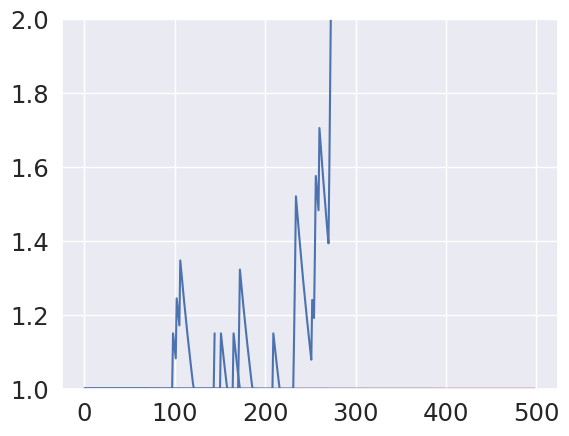

In [9]:
for weights, converged in bpws:
    plt.plot(weights, "b" if converged else "r")
    plt.ylim(1, 2)
        
weight_inc = lambda x: any(w > 1 for w in x[0])
unstable = list(filter(weight_inc, bpws))
stable = list(filter(lambda x: not weight_inc(x), bpws))

print(f"stable: {len([x for _, x in stable if x])}/{len(stable)}")
print(f"unstable: {len([x for _, x in unstable if x])}/{len(unstable)}")
    